# Spacy: Sentiment Anlysis on IMDB movie Reviews using Word2vec Embedding

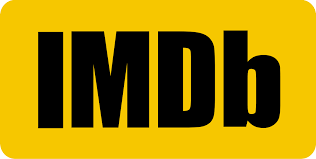

In [1]:
!pip install spacy
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 1.3MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp37-none-any.whl size=829180945 sha256=35ab822374e7de55197067677d824f20f4546db5955e3c7e76c3023d19d7d34d
  Stored in directory: /tmp/pip-ephem-wheel-cache-0reax7j5/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [63]:
import spacy
import en_core_web_lg
import re
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from bs4 import BeautifulSoup
import unicodedata
from textblob import TextBlob

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.svm import LinearSVC

In [5]:
nlp = en_core_web_lg.load()

In [7]:
def get_wordcounts(x):
	length = len(str(x).split())
	return length

In [8]:
def get_charcounts(x):
	s = x.split()
	x = ''.join(s)
	return len(x)

In [9]:
def get_avg_wordlength(x):
	count = get_charcounts(x)/get_wordcounts(x)
	return count

In [10]:
def get_stopwords_counts(x):
	l = len([t for t in x.split() if t in stopwords])
	return l

In [11]:
def get_hashtag_counts(x):
	l = len([t for t in x.split() if t.startswith('#')])
	return l

In [12]:
def get_mentions_counts(x):
	l = len([t for t in x.split() if t.startswith('@')])
	return l

In [13]:

def get_digit_counts(x):
	digits = re.findall(r'[0-9,.]+', x)
	return len(digits)

In [14]:
def get_digit_counts(x):
	digits = re.findall(r'[0-9,.]+', x)
	return len(digits)

In [15]:
def get_uppercase_counts(x):
	return len([t for t in x.split() if t.isupper()])

In [16]:
def get_emails(x):
	emails = re.findall(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+\b)', x)
	counts = len(emails)

	return counts, emails

In [17]:
def remove_emails(x):
	return re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", x)

In [18]:
def get_urls(x):
	urls = re.findall(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', x)
	counts = len(urls)

	return counts, urls

In [19]:
def remove_urls(x):
	return re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , x)

In [20]:
def remove_rt(x):
	return re.sub(r'\brt\b', '', x).strip()

In [21]:
def remove_special_chars(x):
	x = re.sub(r'[^\w ]+', "", x)
	x = ' '.join(x.split())
	return x

In [22]:
def remove_html_tags(x):
	return BeautifulSoup(x, 'lxml').get_text().strip()

In [23]:
def remove_accented_chars(x):
	x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
	return x

In [24]:
def remove_stopwords(x):
	return ' '.join([t for t in x.split() if t not in stopwords])	

In [25]:
def make_base(x):
	x = str(x)
	x_list = []
	doc = nlp(x)
	
	for token in doc:
		lemma = token.lemma_
		if lemma == '-PRON-' or lemma == 'be':
			lemma = token.text

		x_list.append(lemma)
	return ' '.join(x_list)

In [26]:
def get_value_counts(df, col):
	text = ' '.join(df[col])
	text = text.split()
	freq = pd.Series(text).value_counts()
	return freq

In [27]:
def remove_common_words(x, freq, n=20):
	fn = freq[:n]
	x = ' '.join([t for t in x.split() if t not in fn])
	return x

In [28]:
def remove_rarewords(x, freq, n=20):
	fn = freq.tail(n)
	x = ' '.join([t for t in x.split() if t not in fn])
	return x

In [29]:
def remove_dups_char(x):
	x = re.sub("(.)\\1{2,}", "\\1", x)
	return x

In [30]:
def spelling_correction(x):
	x = TextBlob(x).correct()
	return x

In [31]:
def get_basic_features(df):
	if type(df) == pd.core.frame.DataFrame:
		df['char_counts'] = df['text'].apply(lambda x:get_charcounts(x))
		df['word_counts'] = df['text'].apply(lambda x:get_wordcounts(x))
		df['avg_wordlength'] = df['text'].apply(lambda x:get_avg_wordlength(x))
		df['stopwords_counts'] = df['text'].apply(lambda x:get_stopwords_counts(x))
		df['hashtag_counts'] = df['text'].apply(lambda x:get_hashtag_counts(x))
		df['mentions_counts'] = df['text'].apply(lambda x:get_mentions_counts(x))
		df['digits_counts'] = df['text'].apply(lambda x:get_digit_counts(x))
		df['uppercase_counts'] = df['text'].apply(lambda x:get_uppercase_counts(x))
	else:
		print('ERROR: This function takes only Pandas DataFrame')

In [34]:
df = pd.read_csv('moviereviews.tsv', sep = '\t')

In [35]:
df.head()

,label,review
0,neg,how do films like mouse hunt get into theatres...
1,neg,some talented actresses are blessed with a dem...
2,pos,this has been an extraordinary year for austra...
3,pos,according to hollywood movies made in last few...
4,neg,my first press screening of 1998 and already i...


In [36]:
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = remove_emails(x)
    x = remove_urls(x)
    x = remove_html_tags(x)
    x = remove_rt(x)
    x = remove_accented_chars(x)
    x = remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    x = make_base(x)
    x = remove_stopwords(x)
    make_base
        
    return x

In [41]:
df['review'] = df['review'].apply(lambda x: get_clean(x))

In [ ]:
df.head()

## word2vec Conversion

In [42]:
def get_vec(x):
  doc = nlp(x)
  vec = doc.vector
  return vec

In [43]:
df['vec'] = df['review'].apply(lambda x: get_vec(x))

In [44]:
df.head()

,label,review,vec
0,neg,film like mouse hunt theatre law diabolical lo...,"[-0.06373213, -0.014791698, -0.043276977, -0.0..."
1,neg,talented actress bless demonstrate wide acting...,"[-0.060514063, 0.10852452, -0.0699839, -0.0061..."
2,pos,extraordinary year australian film shine scoop...,"[-0.019276105, 0.08678125, -0.022997232, -0.01..."
3,pos,accord hollywood movie decade life small town ...,"[0.052097797, 0.041514337, 0.020066146, 0.0244..."
4,neg,press screening 1998 prime candidate bad year ...,"[-0.029647125, 0.04197969, -0.07493527, -0.009..."


In [45]:
X = df['vec'].to_numpy()
X = X.reshape(-1, 1)

In [46]:
X.shape

(2000, 1)

In [50]:
X[1]

array([array([-6.05140626e-02,  1.08524524e-01, -6.99838996e-02, -6.15728553e-03,
        5.51669225e-02,  1.39517272e-02,  3.92269753e-02, -1.11439049e-01,
        2.96774246e-02,  1.63691354e+00, -6.76779747e-02, -6.39094855e-04,
       -2.18784604e-02, -3.28014567e-02, -7.24309534e-02,  3.92308123e-02,
        9.30500124e-03,  7.23430216e-01, -7.72650093e-02, -1.49337407e-02,
        1.84103400e-02, -9.10724029e-02,  2.96378285e-02, -8.29202384e-02,
        4.88922708e-02,  3.51442359e-02, -3.50006670e-02, -1.10688591e-02,
       -1.18661905e-02, -6.76927343e-02, -9.41737741e-02,  3.00515480e-02,
       -7.88533837e-02,  3.69318761e-02,  8.63113478e-02, -2.28764955e-02,
        3.93185876e-02,  5.70956385e-03, -8.51338729e-02,  5.13565121e-03,
        5.96090667e-02, -1.09776361e-02, -4.86078896e-02, -5.98297678e-02,
        3.95146385e-02, -2.42410153e-02, -1.00070924e-01,  1.77012701e-02,
        1.20957745e-02,  2.50435881e-02,  5.02591813e-03,  5.71302231e-03,
        2.73334533

In [51]:
X = np.concatenate(np.concatenate(X, axis = 0), axis = 0).reshape(-1, 300)

In [52]:
X.shape

(2000, 300)

In [54]:
y = df['label']

In [56]:
# train test split 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 1,stratify = y)


In [57]:
X_train.shape, X_test.shape

((1600, 300), (400, 300))

## Building Classifier

In [58]:
clf = LogisticRegression(solver='liblinear')
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [59]:
y_pred = clf.predict(X_test)

In [61]:
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score {}%".format(round((accuracy_score(y_test,y_pred)*100),2)))
print(classification_report(y_test,y_pred))

[[163  37]
 [ 39 161]]
Accuracy Score 81.0%
              precision    recall  f1-score   support

         neg       0.81      0.81      0.81       200
         pos       0.81      0.81      0.81       200

    accuracy                           0.81       400
   macro avg       0.81      0.81      0.81       400
weighted avg       0.81      0.81      0.81       400



In [64]:
clf=LinearSVC(class_weight='balanced')
clf.fit(X_train,y_train)

LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [65]:
y_pred=clf.predict(X_test)

In [66]:
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score {}%".format(round((accuracy_score(y_test,y_pred)*100),2)))
print(classification_report(y_test,y_pred))

[[165  35]
 [ 39 161]]
Accuracy Score 81.5%
              precision    recall  f1-score   support

         neg       0.81      0.82      0.82       200
         pos       0.82      0.81      0.81       200

    accuracy                           0.81       400
   macro avg       0.82      0.81      0.81       400
weighted avg       0.82      0.81      0.81       400



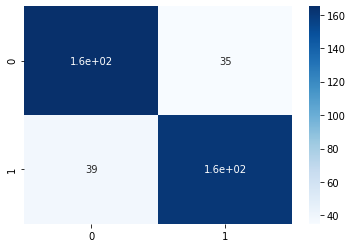

In [67]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, cmap='Blues')

## Test Against New Messages

In [72]:
def pred(msg):
  msg=get_clean(msg)
  vec=get_vec(msg)
  prediction = clf.predict(vec.reshape(1, -1))
  return print(prediction)

In [73]:
pred("this mobile is rellay good, i like")

['pos']
